# Further experimentation

This notebook intends to 
- test pymc-bart implementation with rust (implemented in pymc-bart-rs, but experimental) --> most applicable for this project, potentially faster iteration
- time-slice-cross-validation with CSRP (continuous ranked probability score) --> does not necessarily lead to model improvement, but this is a more "technically-sound" approach to model evaluation
- try pareto-NBD with time varying covariates (implemented in PyMC marketing) --> alternative method that might work better than BART on our dataset, although in general BART works better 

Potential future work 
- BG/NBD with time varying covariates implementation (not currently implemented in library)

## Notebook Setup

In [2]:
import project_utils
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import graphviz
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import xarray as xr
import seaborn as sns
import pandas as pd

import pymc as pm 
import pymc_bart as pmb
import pytensor
import pytensor.tensor as pt

# from pymc_bart.split_rules import ContinuousSplitRule, SubsetSplitRule
from scipy.special import logit
from sklearn.preprocessing import MaxAbsScaler, LabelEncoder
from sklearn.metrics import (
    mean_absolute_percentage_error
)
from warnings import filterwarnings
filterwarnings("ignore", category=UserWarning, module="pymc")

## Data loading & Preprocessing

In our dataset we observe order level data. For each order entry, we have an associated date, order timestamp, customer ID, and revenue.

In [3]:
transactions = project_utils.load_transactions('./transactions.csv')
transactions

,CUSTOMER_KEY,ORDER_KEY,DATE_KEY,ORDER_TIMESTAMP,FULL_REVENUE
0,1002115858489.0,3754939678860,2021-07-12,2021-07-12 12:10:45,35.00
1,1002260725817.0,3729385947276,2021-06-04,2021-06-04 12:04:36,148.00
2,1002260725817.0,3743016845452,2021-06-23,2021-06-23 12:05:46,172.00
3,1002260725817.0,3755584585868,2021-07-13,2021-07-13 07:49:00,247.00
4,1002260725817.0,3764388561036,2021-07-26,2021-07-26 13:47:14,125.00
...,...,...,...,...,...
633694,999645773881.0,4403813122188,2023-02-23,2023-02-23 10:13:03,150.00
633695,999645773881.0,4426178396300,2023-03-16,2023-03-16 10:50:07,44.00
633696,999645773881.0,4451106095244,2023-04-13,2023-04-13 09:33:48,112.00
633697,999645773881.0,4485327487116,2023-05-23,2023-05-23 11:04:43,60.00


In [22]:
transactions = project_utils.preprocess_transactions(transactions)
transactions

,CUSTOMER_KEY,ORDER_KEY,DATE_KEY,ORDER_TIMESTAMP,FULL_REVENUE,WEEK,MONTH,COHORT_x,COHORT_y,COHORT
0,1002115858489.0,3754939678860,2021-07-12,2021-07-12 12:10:45,35.00,2021-07-12,2021-07-01,2021-07-01,2021-07-01,2021-07-01
1,1002260725817.0,3729385947276,2021-06-04,2021-06-04 12:04:36,148.00,2021-05-31,2021-06-01,2021-06-01,2021-06-01,2021-06-01
2,1002260725817.0,3743016845452,2021-06-23,2021-06-23 12:05:46,172.00,2021-06-21,2021-06-01,2021-06-01,2021-06-01,2021-06-01
3,1002260725817.0,3755584585868,2021-07-13,2021-07-13 07:49:00,247.00,2021-07-12,2021-07-01,2021-06-01,2021-06-01,2021-06-01
4,1002260725817.0,3764388561036,2021-07-26,2021-07-26 13:47:14,125.00,2021-07-26,2021-07-01,2021-06-01,2021-06-01,2021-06-01
...,...,...,...,...,...,...,...,...,...,...
633694,999645773881.0,4403813122188,2023-02-23,2023-02-23 10:13:03,150.00,2023-02-20,2023-02-01,2021-05-01,2021-05-01,2021-05-01
633695,999645773881.0,4426178396300,2023-03-16,2023-03-16 10:50:07,44.00,2023-03-13,2023-03-01,2021-05-01,2021-05-01,2021-05-01
633696,999645773881.0,4451106095244,2023-04-13,2023-04-13 09:33:48,112.00,2023-04-10,2023-04-01,2021-05-01,2021-05-01,2021-05-01
633697,999645773881.0,4485327487116,2023-05-23,2023-05-23 11:04:43,60.00,2023-05-22,2023-05-01,2021-05-01,2021-05-01,2021-05-01


We observe some seasonality effects in our dataset.

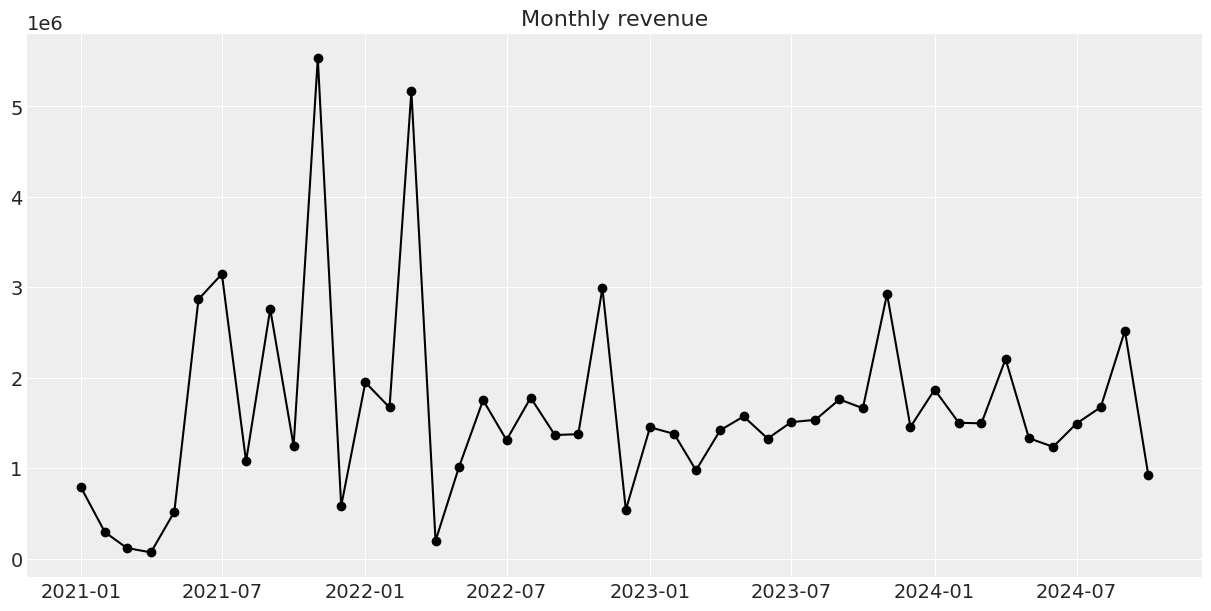

In [8]:
plt.figure(figsize=(12,6))
plt.plot(
    transactions.groupby(['MONTH'])['FULL_REVENUE'].sum(),
    color = "black",
    marker = 'o'
)
plt.title("Monthly revenue")
plt.show()

We pivot our transactions-view dataframe into a cohort-view dataframe. For each cohort and each period, we observe the number of active users and revenue.

In [23]:
cohort = project_utils.preprocess_transactions_to_cohort(transactions)
cohort

,cohort,period,n_active_users,revenue,n_users,age,cohort_age,retention,revenue_per_user,revenue_per_active_user
0,2021-01-01,2021-01-01,4795.0,793272.36,4795.0,1386.0,0.0,1.000000,165.437406,165.437406
1,2021-01-01,2021-02-01,201.0,28250.62,4795.0,1386.0,31.0,0.041919,5.891683,140.550348
2,2021-01-01,2021-03-01,126.0,23775.12,4795.0,1386.0,59.0,0.026277,4.958315,188.691429
3,2021-01-01,2021-04-01,91.0,7701.63,4795.0,1386.0,90.0,0.018978,1.606179,84.633297
4,2021-01-01,2021-05-01,418.0,49701.21,4795.0,1386.0,120.0,0.087174,10.365216,118.902416
...,...,...,...,...,...,...,...,...,...,...
1628,2024-10-01,2025-06-01,NaN,NaN,1076.0,17.0,243.0,NaN,NaN,NaN
1629,2024-10-01,2025-07-01,NaN,NaN,1076.0,17.0,273.0,NaN,NaN,NaN
1630,2024-10-01,2025-08-01,NaN,NaN,1076.0,17.0,304.0,NaN,NaN,NaN
1631,2024-10-01,2025-09-01,NaN,NaN,1076.0,17.0,335.0,NaN,NaN,NaN


<Axes: xlabel='period', ylabel='cohort'>

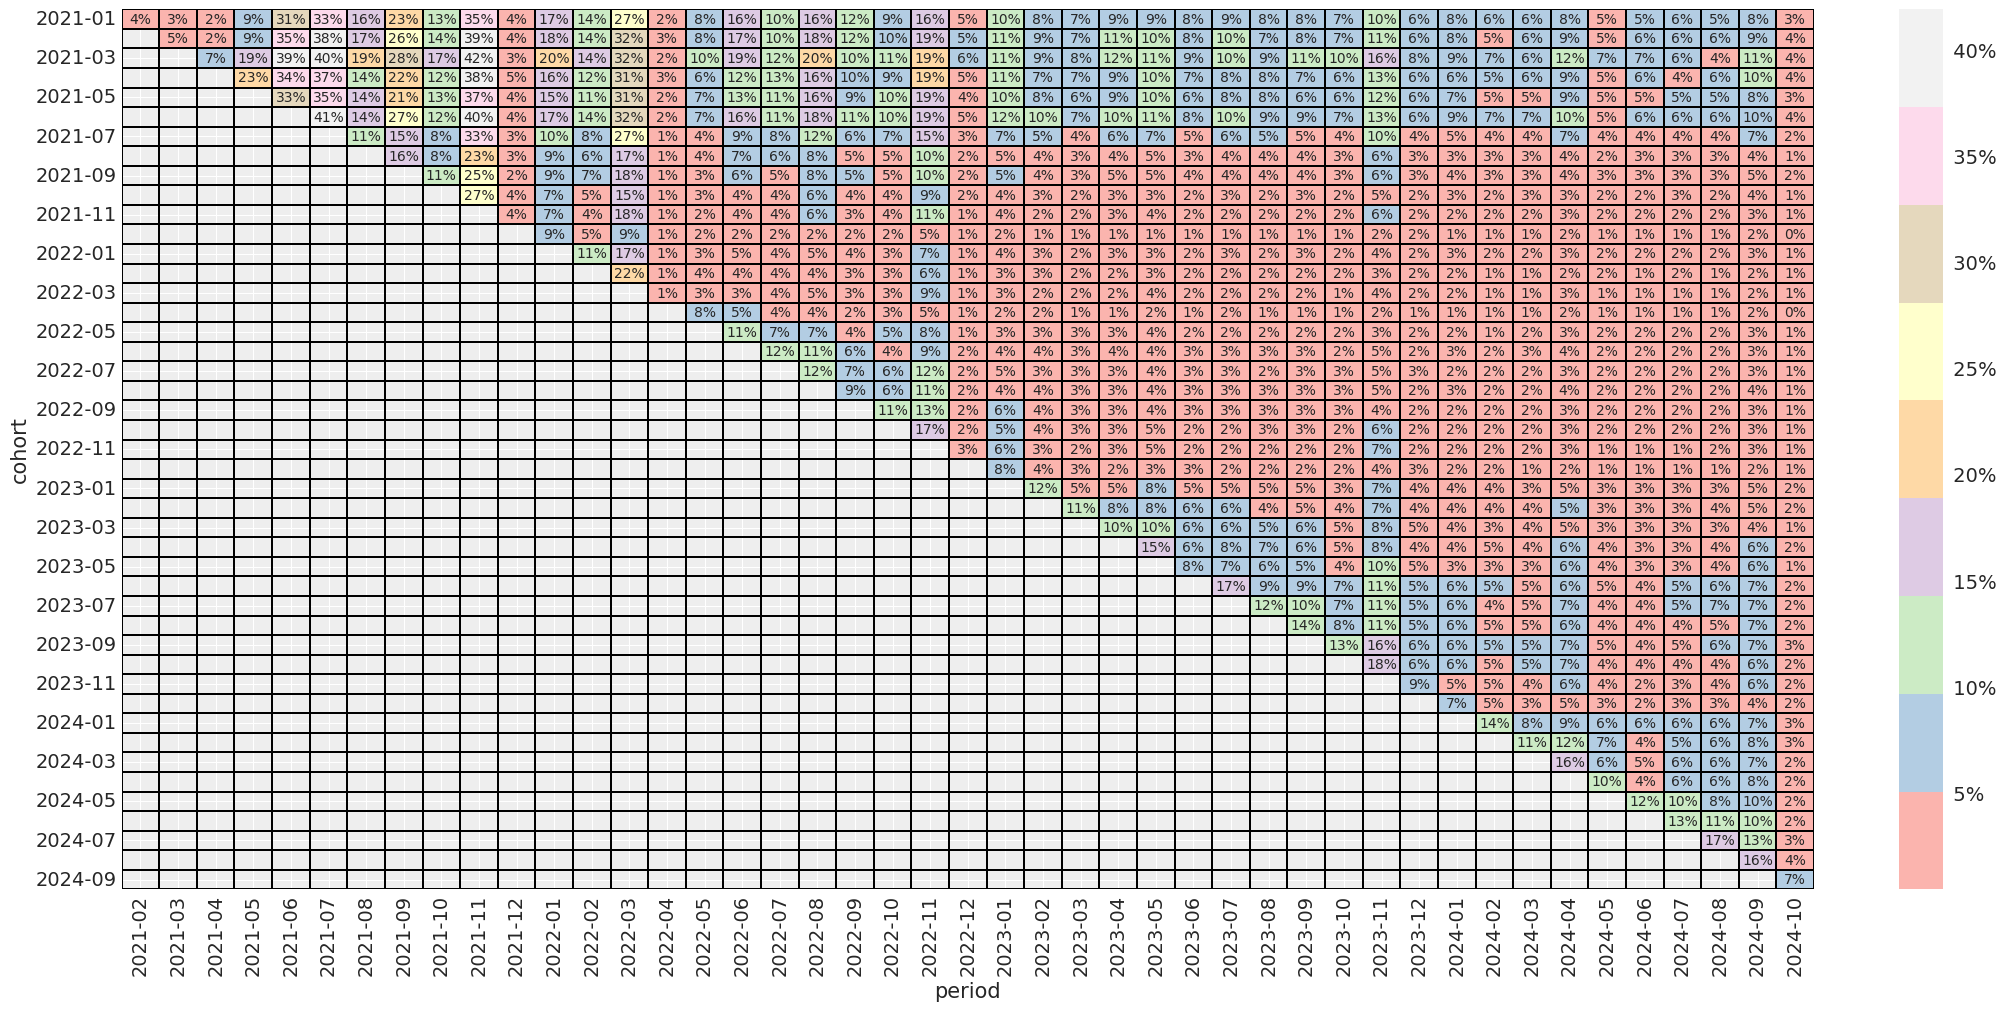

In [10]:
fig, ax = plt.subplots(figsize = (20, 10))
fmt = lambda x, _ : f"{x: 0.0%}"
max_cohort = cohort['cohort'].max().strftime("%Y-%m-%d")

cohort.assign(
    cohort=lambda df: df["cohort"].dt.strftime("%Y-%m"),
    period=lambda df: df["period"].dt.strftime("%Y-%m"),
).query(
        "cohort_age != 0 & period < @max_cohort" 
).filter(
    ["cohort", "period", "retention"]
).pivot(
    index = "cohort",
    columns = "period",
    values = "retention"
).pipe(
    (sns.heatmap, "data"),
    cmap="Pastel1",
    linewidths=0.2,
    linecolor="black",
    annot=True,
    fmt="0.0%",
    cbar_kws={"format": mtick.FuncFormatter(fmt)},
    ax=ax,
)

## bart-rs Modeling

In [25]:
cutoff = datetime.datetime(2023, 6, 1)
train_df, test_df = project_utils.custom_train_test_split(cutoff, cohort)

In [26]:
train_features = project_utils.preprocess_train_test_data(train_df, mode = "train")
for key in train_features.keys():
    print(f"{key}: {type(train_features[key])}")

obs_idx: <class 'numpy.ndarray'>
n_users: <class 'numpy.ndarray'>
n_active_users: <class 'numpy.ndarray'>
retention: <class 'numpy.ndarray'>
revenue: <class 'numpy.ndarray'>
features: <class 'list'>
x: <class 'pandas.core.frame.DataFrame'>
period: <class 'numpy.ndarray'>
cohorts: <class 'numpy.ndarray'>
cohort_idx: <class 'numpy.ndarray'>
age_scaled: <class 'numpy.ndarray'>
cohort_age_scaled: <class 'numpy.ndarray'>
cohort_encoder: <class 'sklearn.preprocessing._label.LabelEncoder'>
age_scaler: <class 'sklearn.preprocessing._data.MaxAbsScaler'>
cohort_age_scaler: <class 'sklearn.preprocessing._data.MaxAbsScaler'>
period_idx: <class 'numpy.ndarray'>
retention_logit: <class 'numpy.ndarray'>
revenue_per_user: <class 'numpy.ndarray'>
data_red_df: <class 'pandas.core.frame.DataFrame'>


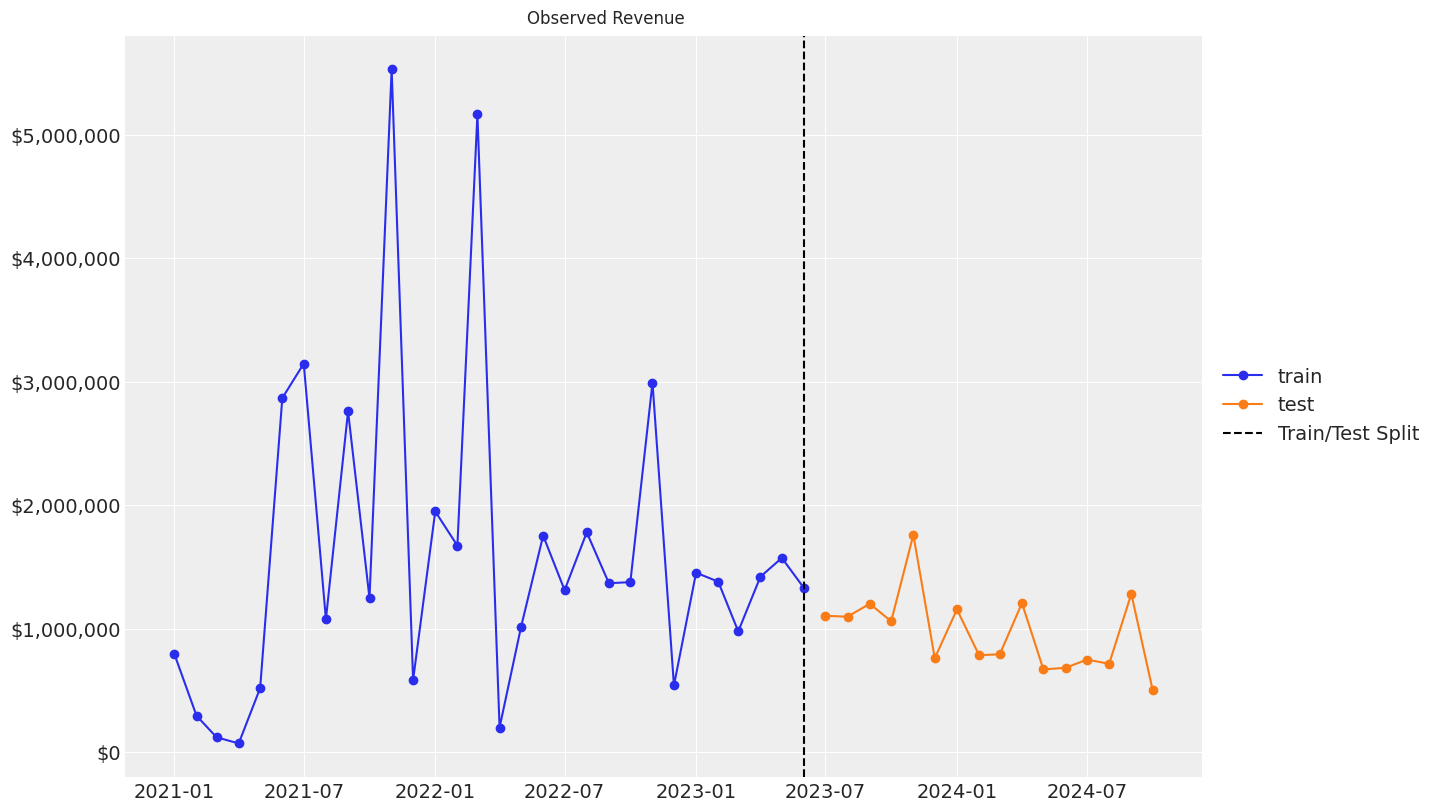

In [13]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(
    train_df.groupby(['period'])['revenue'].sum(),
    label = "train",
    color = 'C0',
    marker = 'o'
)
ax.plot(
    test_df[
        ~test_df['revenue'].isna()
    ].groupby(['period'])['revenue'].sum(),
    label = "test",
    color = 'C1',
    marker = 'o'
)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax.axvline(x=cutoff, color='black', linestyle='--', label='Train/Test Split')
fig.suptitle("Observed Revenue")
fig.legend(loc = "center left", bbox_to_anchor = (1, .5))
plt.show()


In [36]:
for k, v in train_features.items():
    print(f"{k}: {type(v)}, {v.shape if type(v) == np.ndarray else ''}")

obs_idx: <class 'numpy.ndarray'>, (435,)
n_users: <class 'numpy.ndarray'>, (435,)
n_active_users: <class 'numpy.ndarray'>, (435,)
retention: <class 'numpy.ndarray'>, (435,)
revenue: <class 'numpy.ndarray'>, (435,)
features: <class 'list'>, 
x: <class 'pandas.core.frame.DataFrame'>, 
period: <class 'numpy.ndarray'>, (435,)
cohorts: <class 'numpy.ndarray'>, (435,)
cohort_idx: <class 'numpy.ndarray'>, (435,)
age_scaled: <class 'numpy.ndarray'>, (435,)
cohort_age_scaled: <class 'numpy.ndarray'>, (435,)
cohort_encoder: <class 'sklearn.preprocessing._label.LabelEncoder'>, 
age_scaler: <class 'sklearn.preprocessing._data.MaxAbsScaler'>, 
cohort_age_scaler: <class 'sklearn.preprocessing._data.MaxAbsScaler'>, 
period_idx: <class 'numpy.ndarray'>, (435,)
retention_logit: <class 'numpy.ndarray'>, (435,)
revenue_per_user: <class 'numpy.ndarray'>, (435,)
data_red_df: <class 'pandas.core.frame.DataFrame'>, 


We build a revenue model with BART to estimate the number of users and a Gamma component for revenue per transaction.

In [38]:
features = train_features
model = pm.Model(coords = {"features": features["features"]})
with model:
    model.add_coord(
        name="obs", 
        values=features["obs_idx"]
    )
    age_scaled = pm.Data(
        name="age_scaled", 
        value=features["age_scaled"], 
        dims="obs"
    )
    cohort_age_scaled = pm.Data(
        name="cohort_age_scaled", 
        value=features['cohort_age_scaled'], 
        dims="obs"
    )
    x = pm.Data(
        name="x", 
        value=features["x"], 
        dims=("obs", "feature")
    )
    n_users = pm.Data(
        name="n_users", 
        value=features["n_users"], 
        dims="obs"
    )
    n_active_users = pm.Data(
        name="n_active_users", 
        value=features["n_active_users"], 
        dims="obs"
    )
    revenue = pm.Data(
        name="revenue", 
        value=features["revenue"], 
        dims="obs"
    )
    
    month = pm.Data(
        name="month", 
        value=features['x']["month"], 
        dims="obs"
    )

    intercept = pm.Normal(name="intercept", mu=np.array([1,]), sigma=np.array([1,]))
    b_age_scaled = pm.Normal(name="b_age_scaled", mu=0, sigma=1)
    b_cohort_age_scaled = pm.Normal(name="b_cohort_age_scaled", mu=0, sigma=1)
    b_age_cohort_age_interaction = pm.Normal(
        name="b_age_cohort_age_interaction", mu=0, sigma=1
    )
    b_seasonality = pm.Normal(name="b_seasonality", mu=0, sigma=1)
    b_seasonality_age_interaction = pm.Normal(name="b_seasonality_age_interaction", mu=0, sigma=1)
    b_seasonality_cohort_age_interaction = pm.Normal(name="b_seasonality_cohort_age_interaction", mu=0, sigma=1)

    mu = pmb.BART(
        name="mu",
        X=x,
        Y=features["retention_logit"],
        m=50,
        response="mix",
        dims="obs",
    )
    p = pm.Deterministic(name="p", var=pm.math.invlogit(mu), dims="obs")
    eps = np.finfo(float).eps
    p = pt.switch(pt.eq(p, 0), eps, p)
    p = pt.switch(pt.eq(p, 1), 1 - eps, p)

    lam_log = pm.Deterministic(
        name="lam_log",
        var=intercept
        + b_age_scaled * age_scaled
        + b_cohort_age_scaled * cohort_age_scaled
        + b_age_cohort_age_interaction * age_scaled * cohort_age_scaled
        + b_seasonality * month
        + b_seasonality_age_interaction * month * age_scaled 
        + b_seasonality_cohort_age_interaction * month * cohort_age_scaled,
        dims="obs",
    )

    lam = pm.Deterministic(name="lam", var=pm.math.exp(lam_log), dims="obs")

    n_active_users_estimated = pm.Binomial(
        name="n_active_users_estimated",
        n=n_users,
        p=p,
        observed=n_active_users,
        dims="obs",
    )

    revenue_estimated = pm.Gamma(
        name="revenue_estimated",
        alpha=n_active_users_estimated + eps,
        beta=lam,
        observed=revenue,
        dims="obs",
    )


ValueError: Invalid response option: 'mix'. Must be one of {'linear', 'constant'}.

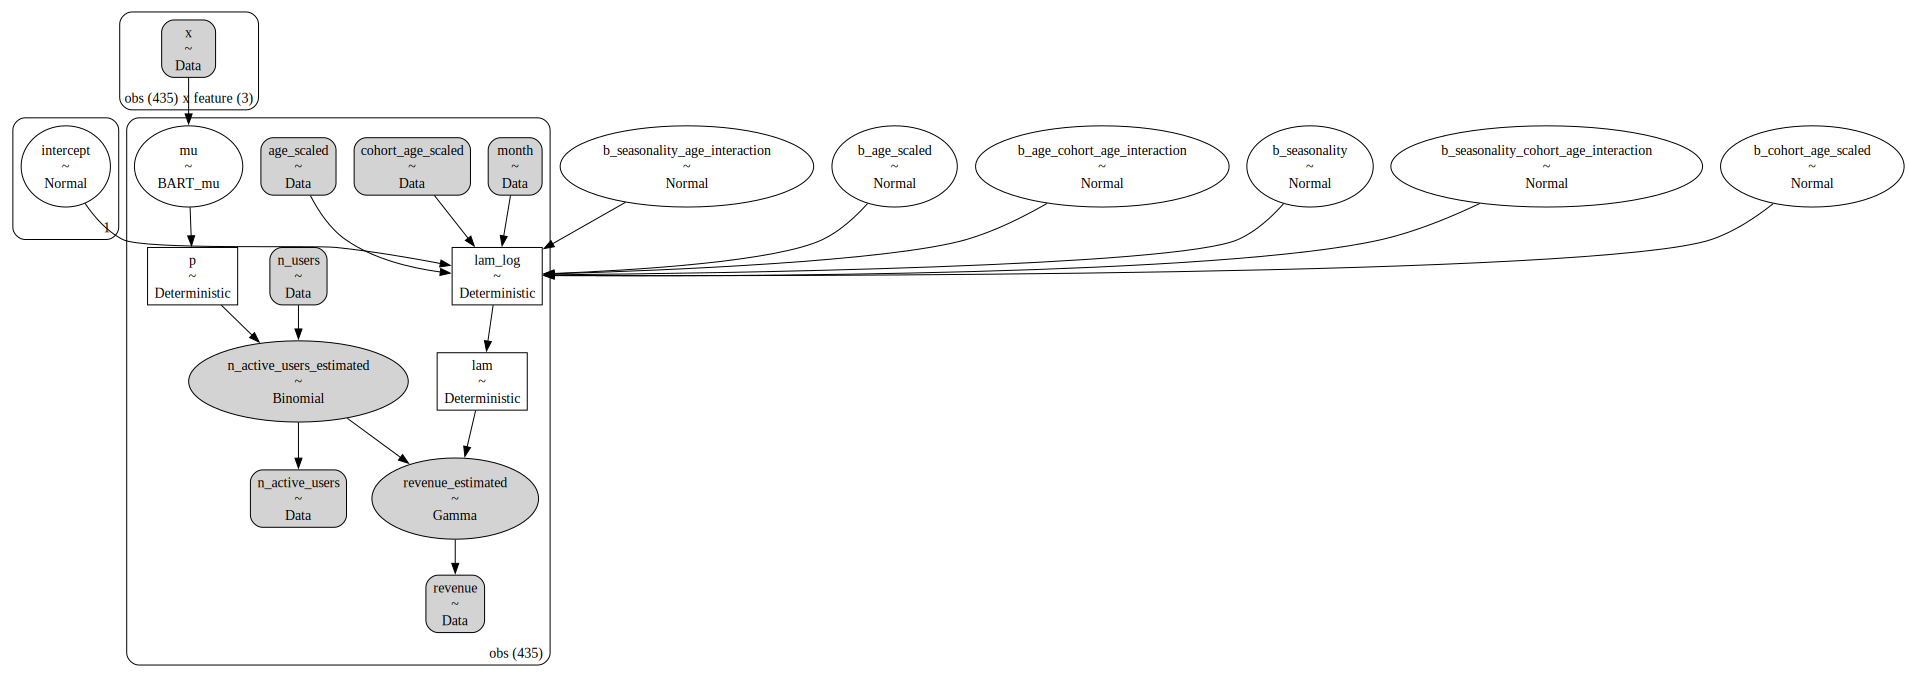

In [29]:
model.to_graphviz()

In [30]:
with model:
    idata = pm.sample(draws = 1000, chains = 4, random_seed=42)
    posterior_predictive = pm.sample_posterior_predictive(trace = idata, random_seed=42)

/Users/fanghema/.pyenv/versions/3.11.7/lib/python3.11/site-packages/pytensor/tensor/random/op.py:94: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(


IndexError: tuple index out of range
Apply node that caused the error: BART_rv{"(m,n),(m),(),(),(),(k)->(m)"}(RNG(<Generator(PCG64) at 0x332568BA0>), [], x, [-3.129201 ... .47469206], 50, 0.95, 2.0, [])
Toposort index: 7
Inputs types: [RandomGeneratorType, TensorType(int64, shape=(0,)), TensorType(float64, shape=(None, None)), TensorType(float64, shape=(435,)), TensorType(int8, shape=()), TensorType(float64, shape=()), TensorType(float32, shape=()), TensorType(float64, shape=(0,))]
Inputs shapes: ['No shapes', (0,), (435, 3), (435,), (), (), (), (0,)]
Inputs strides: ['No strides', (0,), (8, 3480), (8,), (), (), (), (0,)]
Inputs values: [Generator(PCG64) at 0x332568BA0, array([], dtype=int64), 'not shown', 'not shown', array(50, dtype=int8), array(0.95), array(2., dtype=float32), array([], dtype=float64)]
Outputs clients: [[output[8](BART_rv{"(m,n),(m),(),(),(),(k)->(m)"}.0)], [Second(mu, [-2.71547008])]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/Users/fanghema/.pyenv/versions/3.11.7/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/Users/fanghema/.pyenv/versions/3.11.7/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/Users/fanghema/.pyenv/versions/3.11.7/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/sp/cw_2m19j25xbvgpdjz48gclh0000gn/T/ipykernel_48550/398913397.py", line 55, in <module>
    mu = pmb.BART(
  File "/Users/fanghema/.pyenv/versions/3.11.7/lib/python3.11/site-packages/pymc_bart/bart.py", line 179, in __new__
    return super().__new__(cls, name, *params, **kwargs)
  File "/Users/fanghema/.pyenv/versions/3.11.7/lib/python3.11/site-packages/pymc/distributions/distribution.py", line 511, in __new__
    rv_out = cls.dist(*args, **kwargs)
  File "/Users/fanghema/.pyenv/versions/3.11.7/lib/python3.11/site-packages/pymc_bart/bart.py", line 183, in dist
    return super().dist(params, **kwargs)
  File "/Users/fanghema/.pyenv/versions/3.11.7/lib/python3.11/site-packages/pymc/distributions/distribution.py", line 580, in dist
    rv_out = cls.rv_op(*dist_params, size=create_size, **kwargs)

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.